In [42]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import lagrange

In [43]:
x_l=0
x_r=6
L=x_r - x_l 
C=2.0
eps=1e-4
alpha=0.2
S=0.5

In [44]:
def explicit_solution(x):
    return C*np.exp(np.cos(x)-1)

C_l=explicit_solution(x_l)
C_r=explicit_solution(x_r)
y_L=C_l
y_R=C_r

In [45]:
def y_lin(x):
    y_l=explicit_solution(x_l)
    y_r=explicit_solution(x_r)
    
    k=(y_r-y_l)/(x_r-x_l)
    b=y_l-k*x_l
    
    y=k*np.array(x)+b
    
    return y
    

In [46]:
def init(x):
    
    y_a=explicit_solution(x)
    y_f=y_lin(x)
    
    y=(1-alpha)*y_a + alpha*y_f
    
    return y

In [47]:
def first_der(y, ksi):
    h=ksi[2]-ksi[1]
    f=[]
    f.append((-y[2]+4*y[1]-3*y[0])/(2*h))
    
    l=len(y)
    
    for i in range(1, l-1):
        
        f.append((y[i+1]-y[i-1])/(2*h))
    
    
    f.append((3*y[l-1]-4*y[l-2]+y[l-3])/(2*h))
    
    return np.array(f)

In [48]:
def second_der(y, ksi):
    h=ksi[2]-ksi[1]
    f=[]
    f.append((2*y[0]-5*y[1]+4*y[2]-y[3])/(h**2))
    
    
    for i in range(1, len(y)-1):
        f.append((y[i+1]-2*y[i]+y[i-1])/(h**2))
    
    l=len(y)
    f.append((2*y[l-1]-5*y[l-2]+4*y[l-3]-y[l-4])/(h**2))
    
    return np.array(f)

In [49]:
def build_mesh_ksi(M):
    ksi = np.linspace(0, 1, M)
    
    return ksi

In [50]:
def coord(t):
    x = x_l + (S*(t**2)+(1-S)*t)*L
    
    return x

In [51]:
def build_mesh_x(M):
    ksi=build_mesh_ksi(M)
    x=[coord(t) for t in ksi]
    
    return  np.array(x)

In [52]:
def x_der_ksi(ksi_mesh):
    
    def x_der(t):
        x_der = (2*S*t + 1-S)*L
        return x_der
    
    x_der_array=[x_der(t) for t in ksi_mesh]
    
    return np.array(x_der_array)



x_der2=2*S*L

In [53]:
def first_der_x(y_n, ksi_mesh):
    x=build_mesh_x(len(ksi_mesh))
    dy=first_der(y_n, ksi_mesh)
    dx=x_der_ksi(ksi_mesh)
    
    return dy/dx

In [54]:
def second_der_x(y_n, ksi_mesh):
    x=build_mesh_x(len(ksi_mesh))
    ddv=second_der(y_n, ksi_mesh)
    dv=first_der(y_n, ksi_mesh)
    dx=x_der_ksi(ksi_mesh)
    
    res=ddv/((dx)**2) - dv*x_der2/(x_der_ksi(ksi_mesh))**3
    
    return res

In [55]:
def q_coef(y_n, ksi):
    der=first_der_x(y_n, ksi)
    
    q=2*der/y_n
    
    return q
    

In [56]:
def p_coef(y_n, ksi):
    x=build_mesh_x(len(ksi))
    der=first_der_x(y_n, ksi)
    
    p = -(der/y_n)**2 - np.cos(x)
    
    return p
    

In [57]:
def phi_coef(y_n, ksi):
    x=build_mesh_x(len(ksi))
    dy=first_der_x(y_n, ksi)
    ddy=second_der_x(y_n, ksi)
    
    phi=(((dy)**2)/y_n) - y_n*np.cos(x) - ddy
    
    return phi

In [58]:
n_nearest=4
def find_nearest(t, x_mesh):
    index_list=[]
    metric_dict=[abs(t-x_mesh[i]) for i in range(len(x_mesh))]
    for i in range(n_nearest):
        val=min(metric_dict)
        index_list.append(metric_dict.index(val))
        metric_dict[metric_dict.index(val)]=10**8
    
    metric_dict=[]
    
    return index_list
    
    
    

In [59]:
def interpolate_lagrange_nearest(y, x1, x2):
    result=[]
    
    for t in x2:
        nearest_list=find_nearest(t, x1)
        values=[y[nearest_list[i]] for i in range(n_nearest)]
        var=[x1[nearest_list[i]] for i in range(n_nearest)]
        int_func=lagrange(var, values)
        result.append(int_func(t))
        
    return np.array(result)

In [60]:
def lin_solve(y_n, ksi):
    
    h=ksi[2]-ksi[1]
    
    p_c=p_coef(y_n, ksi)
    q_c=q_coef(y_n, ksi)
    phi_c=phi_coef(y_n, ksi)
    
    dx1=x_der_ksi(ksi)
    dx2=x_der2
    
    
    
    
    l=len(ksi)
    lin_matrix=np.zeros((l, l))
    
    
    lin_matrix[0,0]=1
    lin_matrix[l-1, l-1]=1
    
    for i in range(1, l-1):
        lin_matrix[i, i+1]= 1/((h*dx1[i])**2) - q_c[i]/(2*h*dx1[i]) - dx2/(2*h*((dx1[i])**3))
        lin_matrix[i, i]=-2/((h*dx1[i])**2) - p_c[i]
        lin_matrix[i, i-1]=1/((h*dx1[i])**2) + q_c[i]/(2*h*dx1[i]) + dx2/(2*h*((dx1[i])**3)) 
    
    R=[y_L-y_n[0]]
    
    for i in range(1, l-1):
        R.append(phi_c[i])
        
        
    R.append(y_R - y_n[l-1])
    R=np.array(R)
    R=R

    
    
    
    V=np.linalg.solve(lin_matrix, R)
    
    
    return V
    

In [65]:
M=512
main_mesh_ksi=build_mesh_ksi(M)
main_mesh_x=build_mesh_x(M)
y_n=init(main_mesh_x)
v_array=[]
mesh_array=[]
s_array=[y_n]
counter=0
outer_counter=0
delta_prev=1
delta_h=1
s_error=1
steps_array=[]
norms_array=[]
error_array=[]


while s_error>eps/2:
    M=64
    v_array=[]
    mesh_array=[]
    counter=0
    delta_prev=1
    delta_h=1
    s_error=1
    print(f'Outer iteration {outer_counter} \n')
    

    while delta_h>eps/2:
        x_h=build_mesh_x(M)
        x_h_ksi=build_mesh_ksi(M)
        y_nh=interpolate_lagrange_nearest(y_n, main_mesh_x, x_h)

        v_h=lin_solve(y_nh, x_h_ksi)

        if counter>1:
            vh_inter=interpolate_lagrange_nearest(v_array[counter-1], mesh_array[counter-1], x_h)
            delta_h=max(abs(v_h-vh_inter))
            print(f'Inner iteration {counter}, M = {M}, mesh_size= {len(x_h)}, delta = {delta_h}, R = {delta_prev/delta_h}')
        if counter==1:
            vh_inter=interpolate_lagrange_nearest(v_array[counter-1], mesh_array[counter-1], x_h)
            delta_h=max(abs(v_h-vh_inter))
            print(f'Inner iteration {counter}, M = {M}, mesh_size= {len(x_h)}, delta = {delta_h}')
        if counter==0:
            print(f'Inner iteration {counter}, M = {M}, mesh_size= {len(x_h)}')
        
        
        v_array.append(v_h)
        mesh_array.append(x_h)

        M=M*2
        counter+=1
        eps_h=delta_h
        delta_prev=delta_h
    
    
    v_outer=interpolate_lagrange_nearest(v_h, x_h, main_mesh_x)
    y_n=y_n + v_outer
    s_error=max(abs(explicit_solution(main_mesh_x) - y_n))
    
    s_array.append(y_n)
    error_array.append(s_error)
    norms_array.append(max(abs(v_h)))
    steps_array.append(outer_counter)
    print(f'Outer iter = {outer_counter}, ||v_h|| = {max(abs(v_h))}, error(y_n) = {s_error} \n')
    outer_counter+=1
    
print(f'Convergence, alpha = {alpha}')
    
    
    
    

Outer iteration 0 

Inner iteration 0, M = 64, mesh_size= 64
Inner iteration 1, M = 128, mesh_size= 128, delta = 0.0009071719424462582
Inner iteration 2, M = 256, mesh_size= 256, delta = 0.00022300316374414264, R = 4.067977903161411
Inner iteration 3, M = 512, mesh_size= 512, delta = 5.522495731795363e-05, R = 4.038086665422272
Inner iteration 4, M = 1024, mesh_size= 1024, delta = 1.374737926494729e-05, R = 4.017126192100103
Outer iter = 0, ||v_h|| = 0.24082523565953826, error(y_n) = 0.21209817702955736 

Outer iteration 1 

Inner iteration 0, M = 64, mesh_size= 64
Inner iteration 1, M = 128, mesh_size= 128, delta = 0.0015470444140951167
Inner iteration 2, M = 256, mesh_size= 256, delta = 0.00037781952974147437, R = 4.09466502473732
Inner iteration 3, M = 512, mesh_size= 512, delta = 9.34559073259289e-05, R = 4.042757066429445
Inner iteration 4, M = 1024, mesh_size= 1024, delta = 2.325135364625308e-05, R = 4.019374903834434
Outer iter = 1, ||v_h|| = 0.18241138479222616, error(y_n) = 0.

Solution error = 0.337750428401633
Solution error = 0.21209817702955736
Solution error = 0.031851013875265455
Solution error = 0.0004461267183653028
Solution error = 1.143044023033113e-05


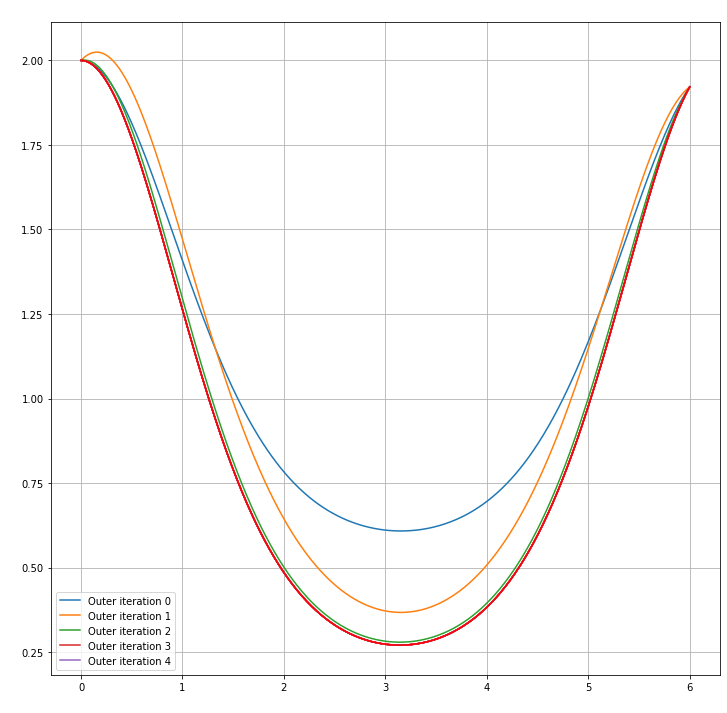

In [62]:

plt.figure(figsize=(12,12))
plt.title('Solutions', color='white')
plt.xlabel('x', color='white')
plt.ylabel('y_n', color='white')
plt.grid()
for i in range(len(s_array)):
    plt.plot(main_mesh_x, s_array[i], label=f'Outer iteration {i}')
    plt.plot(main_mesh_x, explicit_solution(main_mesh_x), color='red')
    plt.legend()
    print(f'Solution error = {max(abs(s_array[i] - explicit_solution(main_mesh_x)))}')

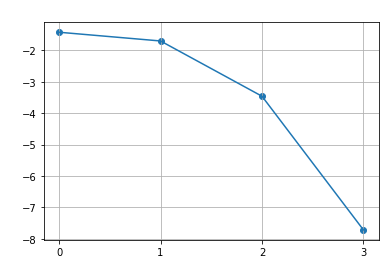

In [63]:
plt.title('Log residual norm (outer iteration number) plot', color='white')
plt.grid()
plt.ylabel('|| v_n ||', color='white')
plt.xlabel('Outer iteration number', color='white')
plt.xticks([i for i in range(len(steps_array))])
plt.plot(steps_array, np.log(norms_array))
plt.scatter(steps_array, np.log(norms_array))
plt.show()

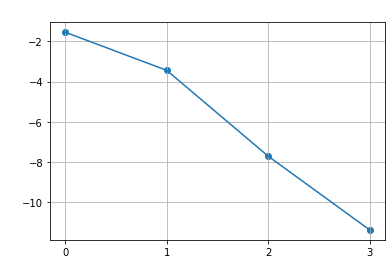

In [64]:
plt.title('Log y_n error (outer iteration number) plot', color='white')
plt.grid()
plt.ylabel('Log y_n error', color='white')
plt.xlabel('Outer iteration number', color='white')
plt.xticks([i for i in range(len(steps_array))])
plt.plot(steps_array, np.log(error_array))
plt.scatter(steps_array, np.log(error_array))
plt.show()

